In [1]:
import sys
sys.path.append('../utils/')

In [2]:
from ImageUtils import *

In [3]:
import numpy as np
import pandas as pd # Needs the package Pandas to be installed. Check Anaconda Environments and Packages.
from sklearn.decomposition import PCA # Needs SciKit Learn package to be installed. Check Anaconda Environments and Packages.4
from sklearn.covariance import LedoitWolf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from collections import Counter
from sklearn.preprocessing import label_binarize
import time
from sklearn import preprocessing
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# Data preparation

## Load dataset

In [4]:
faces94_male = readFaces94MaleFaces(gray=True)
faces94_female = readFaces94FemaleFaces(gray=True)
faces94_malestaff = readFaces94MaleStaffFaces(gray=True)

dataset = np.vstack((faces94_male, faces94_female, faces94_malestaff))

dataset_N, height, width = dataset.shape
dataset.shape

(3059, 200, 180)

## Data centralization and calculate of covariance matrix

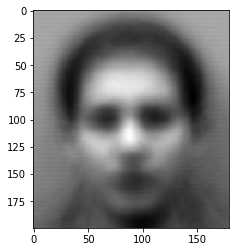

In [5]:
mean_all = np.mean(dataset.reshape(dataset_N, height*width), axis=0).reshape(height, width)
plt.imshow(mean_all, plt.cm.gray)

In [6]:
data=dataset.reshape(dataset_N, height*width) - np.mean(dataset.reshape(dataset_N, height*width), axis=0)
datasetmean=(1/(dataset_N-1))*(np.dot(data,data.T)) # Covariance matrix
print(datasetmean.shape)

(3059, 3059)


# Subspaces method: Eigenfaces

## Singular Value Decomposition.

In [7]:
u,s,vh = np.linalg.svd(datasetmean) # u: eigenvectors in columns; s: eigenvalues; vh = eigenvectors in rows

## Face space: selection of subspace components

### Option 1: Investigator's criteria of variability captured (hyperparameter)

In [8]:
representation_percentage = 0.80 # Selected variability 

In [9]:
sum_eig = np.sum(s)
percentage_variance = np.divide(s, sum_eig)
sum_var = 0
num_var = 0
for i in np.arange(percentage_variance.shape[0]):
    if sum_var >= representation_percentage:
        num_var = i
        break;
    
    sum_var += percentage_variance[i]
    
num_var_select=num_var    
print("Principal components number: ",num_var_select)
print("Percent of variability captured: ",sum_var*100)
print("Images in datasets",dataset_N)

Principal components number:  31
Percent of variability captured:  80.09727373719215
Images in datasets 3059


### Option 2: Investigator's criteria of threshold contribution value (hyperparameter)

First 305 components with  97.58647084236145 percent of variability captured and from which the contribution is less than 0.01%


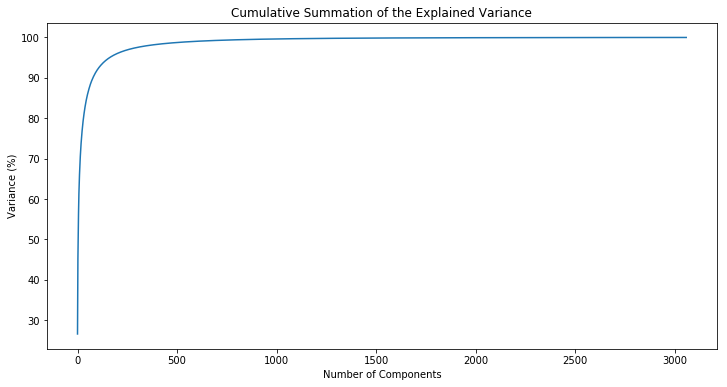

In [10]:
cum_per=np.cumsum(percentage_variance)
for i in range(1,len(s)):
    change=(cum_per[i]-cum_per[i-1])/cum_per[i-1]*100
    if(change<.01):
        num_var=i-1
        print("First",num_var, "components with ",cum_per[num_var]*100,"percent of variability captured and from which the contribution is less than 0.01%")
        break

plt.figure(figsize=(12,6))
plt.plot(cum_per*100)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Cumulative Summation of the Explained Variance')
plt.show()

# Face space

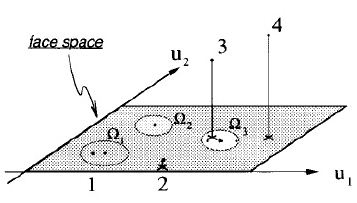

In [11]:
EigenvectorsA=np.dot(data.T,u[:,0:num_var_select])
NormEigenvectorsA = preprocessing.normalize(EigenvectorsA,axis=0, norm='l2')
print(np.linalg.norm(NormEigenvectorsA[:,5],ord=None))#check normalizacion vectores propios de XT.X

1.0000019


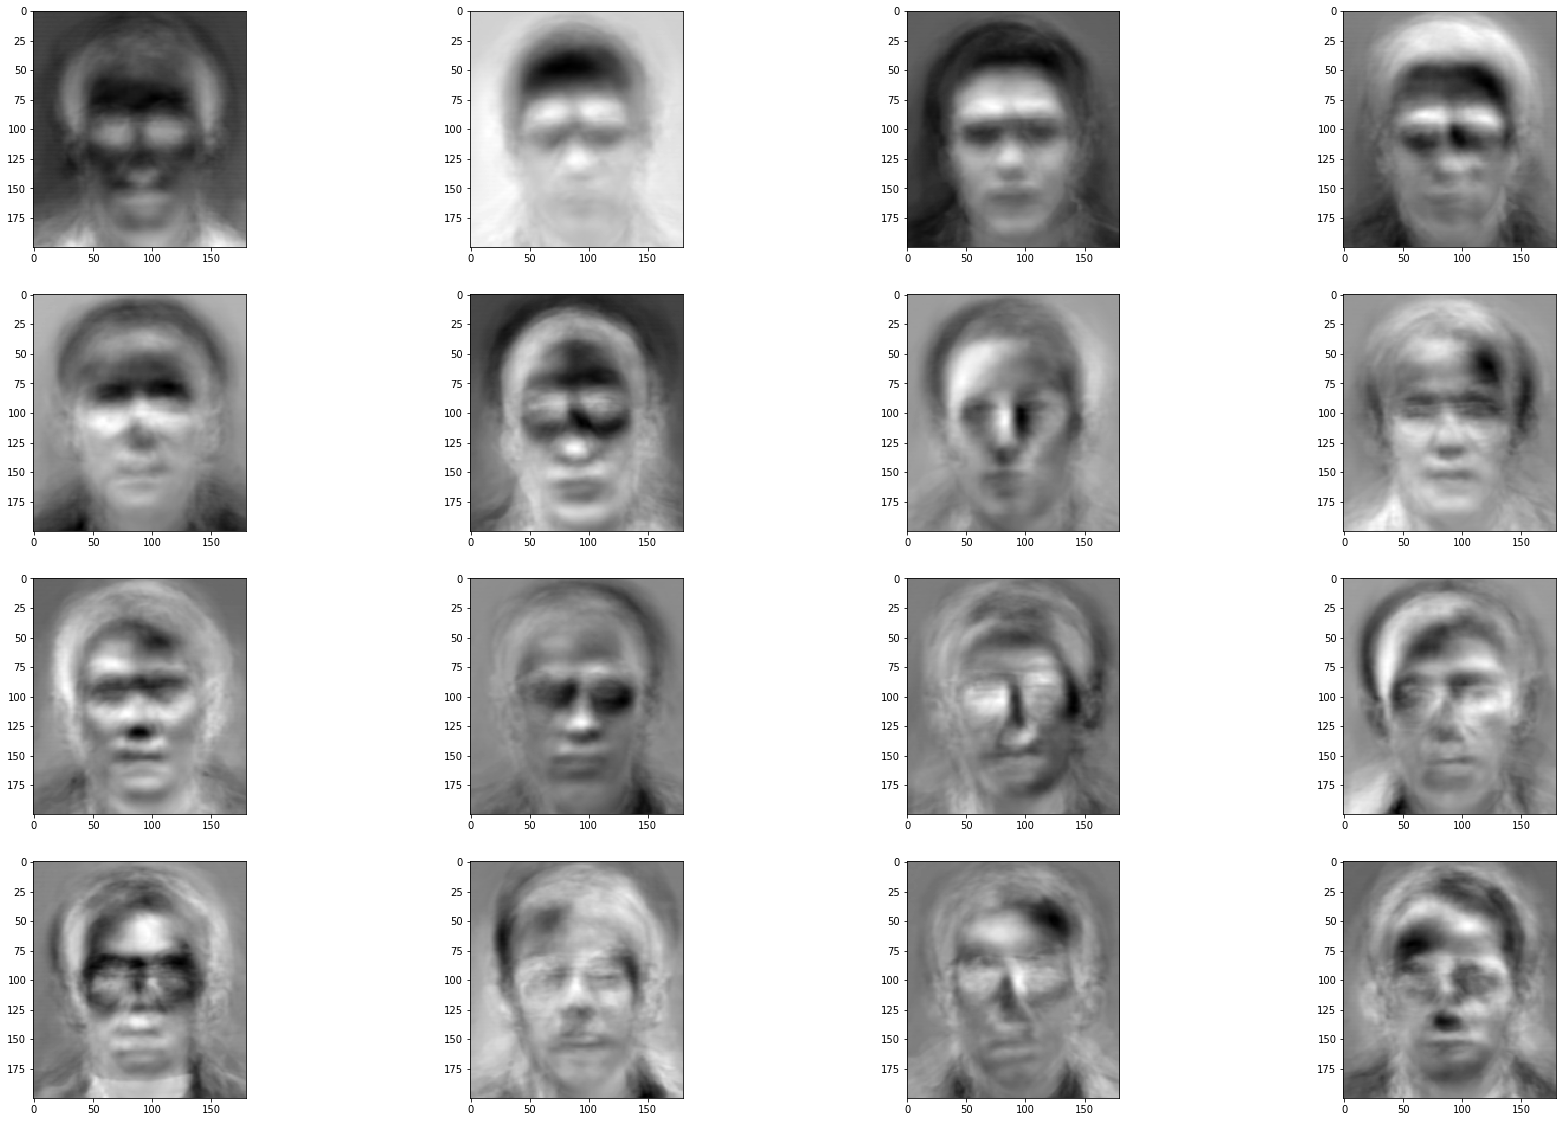

In [12]:
cols = 4
rows = 4
plt.figure(figsize=(30,20))
for i in np.arange(rows * cols):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(NormEigenvectorsA[:,i].reshape(height, width), plt.cm.gray)

# Projection of an image on face space

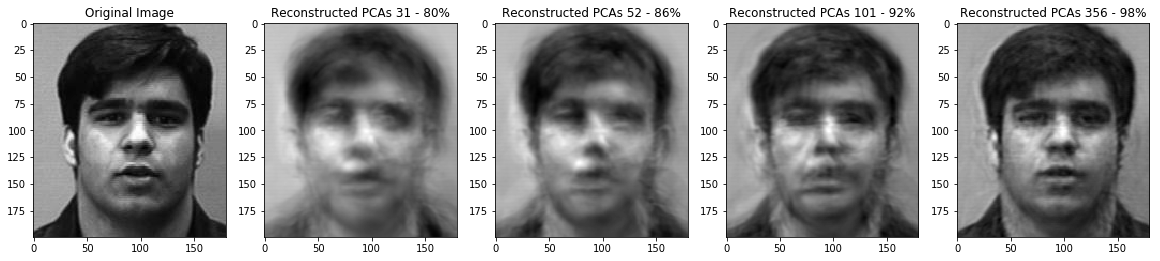

In [13]:
start=0.8
step=0.06
stop=1

facespace(percentage_variance,dataset,data,mean_all,u,dataset_N,height,width,start,step,stop,0)

In [14]:
print("Principal components number: ",num_var_select)
print("Percent of variability captured: ",sum_var*100)
print("Images in datasets",dataset_N)
print("Omega matrix facespace",np.dot(data,NormEigenvectorsA).shape)

Principal components number:  31
Percent of variability captured:  80.09727373719215
Images in datasets 3059
Omega matrix facespace (3059, 31)


### specific image

In [15]:
import ipywidgets as widgets
n=widgets.BoundedFloatText(value=2690,min=0,max=dataset_N,description='image:')
display(n)

BoundedFloatText(value=2690.0, description='image:', max=3059.0)

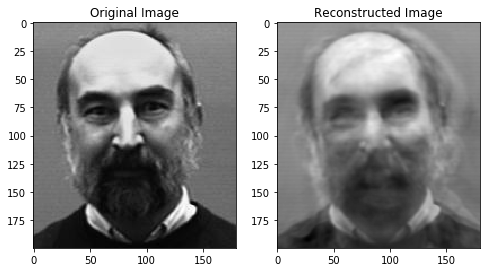

In [16]:
N_image=int(n.value)
specificimage(data,dataset,NormEigenvectorsA,mean_all,N_image,dataset_N,height,width)

### random image

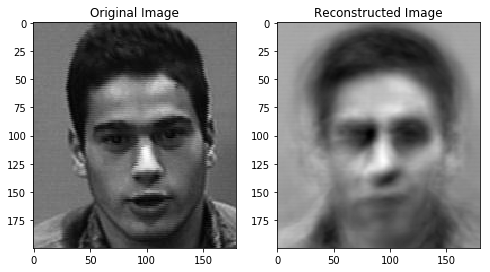

In [17]:
randomimage(data,dataset,NormEigenvectorsA,mean_all,dataset_N,height,width)

# Distances an outliers

In [18]:
dataReconstructed=np.dot(np.dot(data,NormEigenvectorsA),NormEigenvectorsA.T)+mean_all.reshape(height*width)
print(dataReconstructed.shape)

(3059, 36000)


In [19]:
Norm=widgets.Dropdown(options=['1', '2', 'inf'],value='2',description='Norm:',disabled=False)
display(Norm)

Dropdown(description='Norm:', index=1, options=('1', '2', 'inf'), value='2')

In [20]:
if str(Norm.value)=='inf':
    ordn=np.inf
else:
    ordn=int(Norm.value)

In [21]:
edistance = np.linalg.norm(np.subtract(dataReconstructed, dataset.reshape(dataset_N, height*width)), ord=ordn, axis=1)
print(edistance.shape)

(3059,)


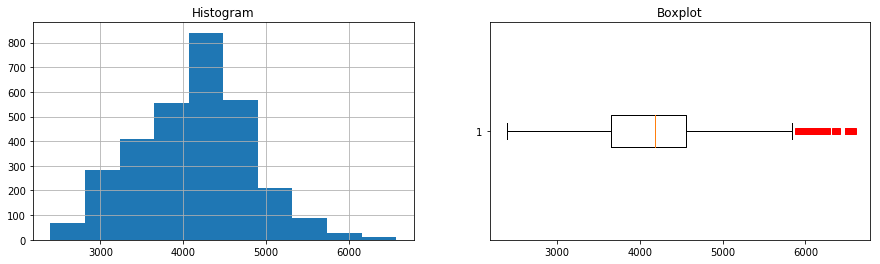

In [22]:
histbox(edistance)

In [23]:
threshold, outliers, zsort, indexsort, z=outlierseigenfaces(edistance,3)

print('Outliers threshold method=',np.size(outliers))
print('threshold=',threshold)
CVresult={'outliers distance':outliers,'z':zsort}
df = pd.DataFrame(CVresult)
df.sort_values('z', axis = 0, ascending = False, inplace = True, na_position ='first') 
df.head(np.size(outliers)) 

Outliers threshold method= 12
threshold= 3


,outliers distance,z
11,6572.463867,3.580785
10,6548.206543,3.545166
9,6545.279785,3.540868
8,6528.583496,3.516351
7,6512.760742,3.493116
6,6512.387695,3.492568
5,6378.285156,3.295651
4,6358.770996,3.266996
3,6264.098145,3.127977
2,6235.145020,3.085462


#### low and high distance

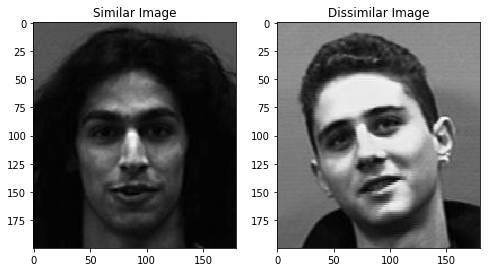

In [24]:
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(1,2,1)
plt.title("Similar Image")
ax1.imshow(dataset[indexsort[0]], plt.cm.gray)
ax2 = fig.add_subplot(1,2,2)
plt.title("Dissimilar Image")
ax2.imshow(dataset[indexsort[-1]], plt.cm.gray)

#### high distances

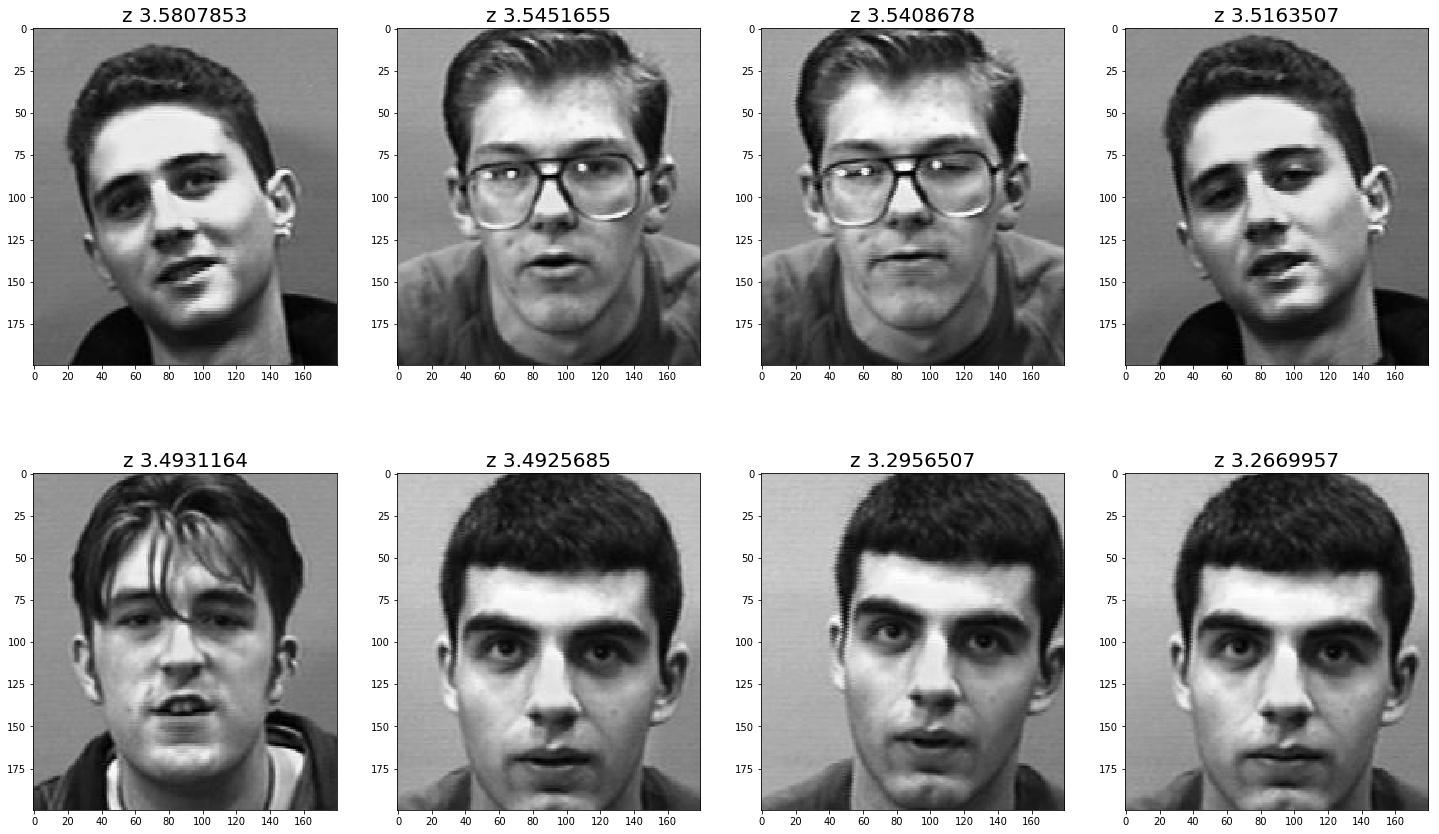

In [25]:
cols = 4
rows = 2
plt.figure(figsize=(25,15))
for i in np.arange(rows * cols):
    plt.subplot(rows, cols, i + 1)
    plt.title("z "+str(z[indexsort[-(i+1)]]),fontsize=20)
    plt.imshow(dataset[indexsort[-(i+1)]], plt.cm.gray)

# Face recognition dataset

No pertenece al dataset
7969.402


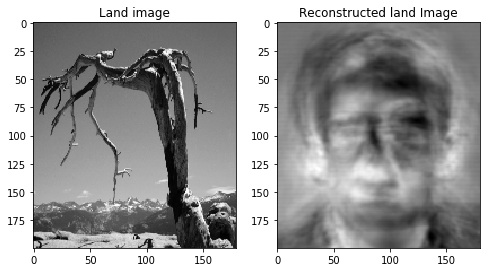

In [26]:
landscapes = np.array(readLandsCapeImage(gray=True))

landimages(landscapes,height,width,mean_all,NormEigenvectorsA,ordn,outliers)

(210, 36000)


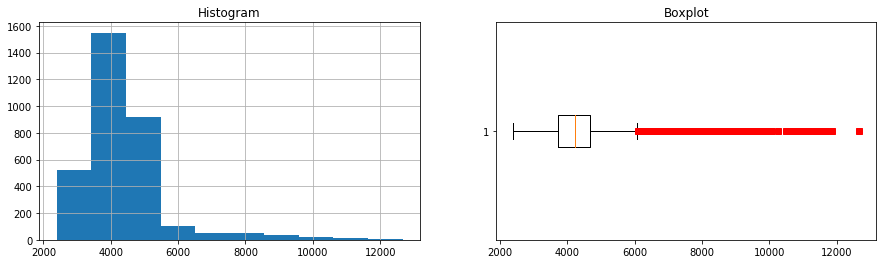

In [27]:
landimage=landscapes.reshape(landscapes.shape[0],height*width)-mean_all.reshape(height*width)
dataReconstructedland=np.dot(np.dot(landimage,NormEigenvectorsA),NormEigenvectorsA.T)+mean_all.reshape(height*width)
print(dataReconstructedland.shape)

edistanceland = np.linalg.norm(np.subtract(dataReconstructedland, landscapes.reshape(landscapes.shape[0], height*width)), ord=ordn, axis=1)
totaldistance=np.append(edistance,edistanceland)
histbox(totaldistance)

TP= 3048 TN= 178 FP= 32 FN= 11
accuracy=  0.9868461303150811


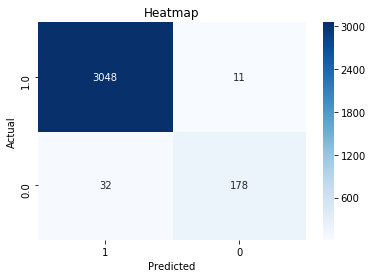

In [28]:
y_true=np.ones(dataset_N)
y_true=np.append(y_true,np.zeros(landscapes.shape[0]))
y_pred=(totaldistance<=outliers[0])*1

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print('TP=', tp,'TN=',tn,'FP=',fp,'FN=', fn)
print('accuracy= ', (tp+tn)/(tp+tn+fp+fn))

plt.figure()
plt.title("Heatmap")
prediction_data = {'y_Actual': y_true,'y_Predicted': y_pred}
df = pd.DataFrame(prediction_data, columns=['y_Actual','y_Predicted'])
confusionmatrix1 = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
ax=sns.heatmap(confusionmatrix1, annot=True,cmap='Blues', fmt='.0f');
ax.invert_yaxis()
ax.invert_xaxis()

#### false positive

distancia 5737.866


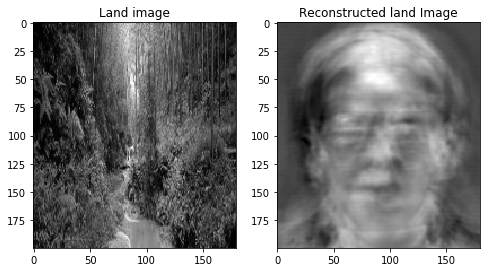

In [29]:
N_land= int(np.where(edistanceland < outliers[0])[0][3])
landimage=landscapes[N_land].reshape(height*width)-mean_all.reshape(height*width)#seleccionar imagen individual
wland=np.dot(landimage,NormEigenvectorsA)#pesos w de cada Eigenface en subespacio generado
Reconstland=np.dot(wland,NormEigenvectorsA.T)+mean_all.reshape(height*width)#es mas claro w*vectores propios transpuestos
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(1,2,1)
plt.title("Land image")
ax1.imshow(landscapes[N_land], plt.cm.gray)
ax2 = fig.add_subplot(1,2,2)
plt.title("Reconstructed land Image")
ax2.imshow(Reconstland.reshape(height, width), plt.cm.gray)
print('distancia',edistanceland[N_land])

In [30]:
accuracy, tncv, fpcv, fncv, tpcv=kfold(y_true,landscapes,dataset,height,width,ordn)
CVresult={'accuracy':accuracy,'tn':tncv,'fp':fpcv,'fn':fncv,'tp':tpcv}
df = pd.DataFrame(CVresult)
df.head()   

KFold(n_splits=5, random_state=42, shuffle=True)
test:  821
faces:  611
landscapes:  210


,accuracy,tn,fp,fn,tp
0,0.947689,170.0,40.0,3.0,609.0
1,0.945255,166.0,44.0,1.0,611.0
2,0.950122,170.0,40.0,1.0,611.0
3,0.944039,166.0,44.0,2.0,610.0
4,0.952497,171.0,39.0,0.0,611.0


## Dataset with landscapes

In [31]:
landscapes = np.array(readLandsCapeImage(gray=True))
datasetfull = np.vstack((dataset,landscapes))

datasetfull_N, height, width = datasetfull.shape
datasetfull.shape

(3269, 200, 180)

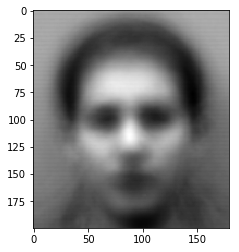

In [32]:
mean_all_full = np.mean(datasetfull.reshape(datasetfull_N, height*width), axis=0).reshape(height, width)
plt.imshow(mean_all_full, plt.cm.gray)

In [33]:
datafull=datasetfull.reshape(datasetfull_N, height*width) - np.mean(datasetfull.reshape(datasetfull_N, height*width), axis=0)
datasetmeanfull=(1/(datasetfull_N-1))*(np.dot(datafull,datafull.T))
print(datasetmeanfull.shape)

(3269, 3269)


In [34]:
u,s,vh = np.linalg.svd(datasetmeanfull)

In [35]:
representation_percentage = 0.80

sum_eig = np.sum(s)
percentage_variance = np.divide(s, sum_eig)
sum_var = 0
num_var = 0
for i in np.arange(percentage_variance.shape[0]):
    if sum_var >= representation_percentage:
        num_var = i
        break;
    
    sum_var += percentage_variance[i]
    
num_var_select=num_var    
print("Principal components number: ",num_var_select)
print("Percent of variability captured: ",sum_var*100)
print("Images in datasets",datasetfull_N)

Principal components number:  38
Percent of variability captured:  80.20748815033585
Images in datasets 3269


First 415 components with  97.31395244598389 percent of variability captured and from which the contribution is less than 0.01%


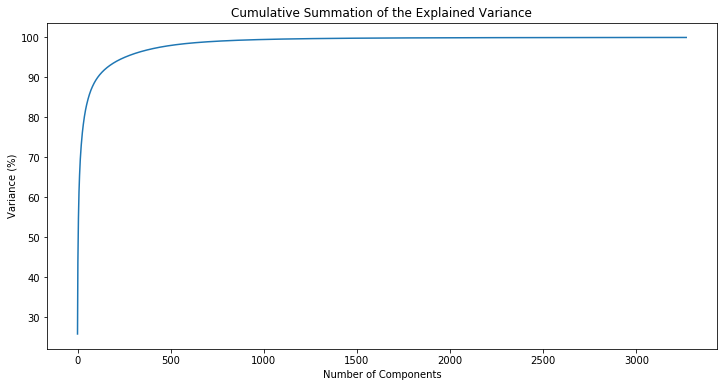

In [36]:
cum_per=np.cumsum(percentage_variance)
for i in range(1,len(s)):
    change=(cum_per[i]-cum_per[i-1])/cum_per[i-1]*100
    if(change<.01):
        num_var=i-1
        print("First",num_var, "components with ",cum_per[num_var]*100,"percent of variability captured and from which the contribution is less than 0.01%")
        break

plt.figure(figsize=(12,6))
plt.plot(cum_per*100)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Cumulative Summation of the Explained Variance')
plt.show()

In [37]:
EigenvectorsA=np.dot(datafull.T,u[:,0:num_var_select])
NormEigenvectorsA = preprocessing.normalize(EigenvectorsA,axis=0, norm='l2')
print(np.linalg.norm(NormEigenvectorsA[:,5],ord=None))#check normalizacion vectores propios de XT.X

1.0000002


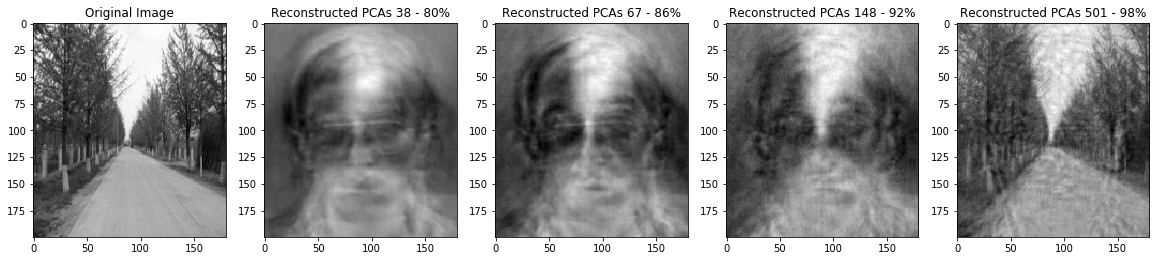

In [38]:
start=0.8
step=0.06
stop=1

facespace(percentage_variance,datasetfull,datafull,mean_all_full,u,datasetfull_N,height,width,start,step,stop,dataset_N)

In [39]:
print("Principal components number: ",num_var_select)
print("Percent of variability captured: ",sum_var*100)
print("Images in datasets",datasetfull_N)
print("Omega matrix facespace",np.dot(datafull,NormEigenvectorsA).shape)

Principal components number:  38
Percent of variability captured:  80.20748815033585
Images in datasets 3269
Omega matrix facespace (3269, 38)


### random image

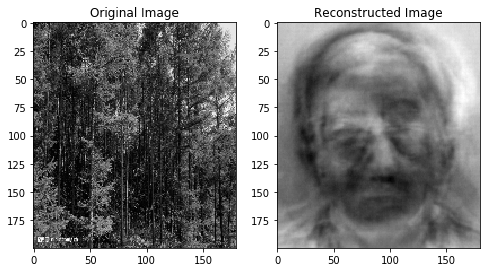

In [40]:
N_image= np.random.randint(3059, high=datasetfull.shape[0], size=1)[0]
Image=datafull[N_image]
w=np.dot(Image,NormEigenvectorsA)
Reconstructed=np.dot(w,NormEigenvectorsA.T)+mean_all_full.reshape(height*width)
example_image = Reconstructed
original_image = datasetfull[N_image]
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(1,2,1)
plt.title("Original Image")
ax1.imshow(original_image, plt.cm.gray)
ax2 = fig.add_subplot(1,2,2)
plt.title("Reconstructed Image")
ax2.imshow(example_image.reshape(height,width), plt.cm.gray)

(3269, 36000)
(3269,)


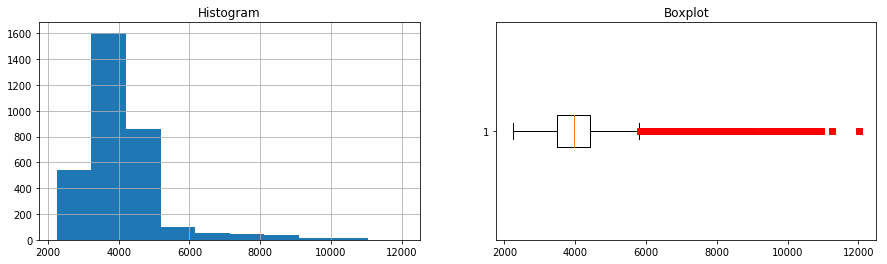

In [41]:
datafullReconstructed=np.dot(np.dot(datafull,NormEigenvectorsA),NormEigenvectorsA.T)+mean_all_full.reshape(height*width)
print(datafullReconstructed.shape)
edistancefull = np.linalg.norm(np.subtract(datafullReconstructed, datasetfull.reshape(datasetfull_N, height*width)), ord=ordn, axis=1)
print(edistancefull.shape)
histbox(edistancefull)

In [42]:
z = np.abs(stats.zscore(edistancefull))
percentil_93, percentil_94 = np.percentile(edistancefull, [93, 94])
outliersindex=np.where(edistancefull > percentil_93)
outliersfull=edistancefull[outliersindex]
zsort=z[outliersindex]
indexsortout=np.argsort(outliersfull)
outliersfull=outliersfull[indexsortout]
zsort=zsort[indexsortout]

indexsort=np.argsort(edistancefull) #indice de imagenes distance de menor a mayor
edistancesort=edistancefull[indexsort] #distancias de imagenes menor a mayor

print('Outliers threshold method=',np.size(outliersfull))
print('percentil_93=',percentil_93)
#print('Q1= ',quartile_1, 'Q3= ',quartile_3)
CVresult={'outliers distancefull':outliersfull,'z':zsort}
df = pd.DataFrame(CVresult)
df.sort_values('z', axis = 0, ascending = False, inplace = True, na_position ='first') 
df.head(10) 

Outliers threshold method= 229
percentil_93= 5338.129804687502


,outliers distancefull,z
228,12022.406250,6.890265
227,11248.841797,6.215658
226,10952.540039,5.957261
225,10922.848633,5.931367
224,10741.217773,5.772972
223,10731.328125,5.764347
222,10700.061523,5.737080
221,10637.156250,5.682222
220,10499.575195,5.562241
219,10480.953125,5.546001


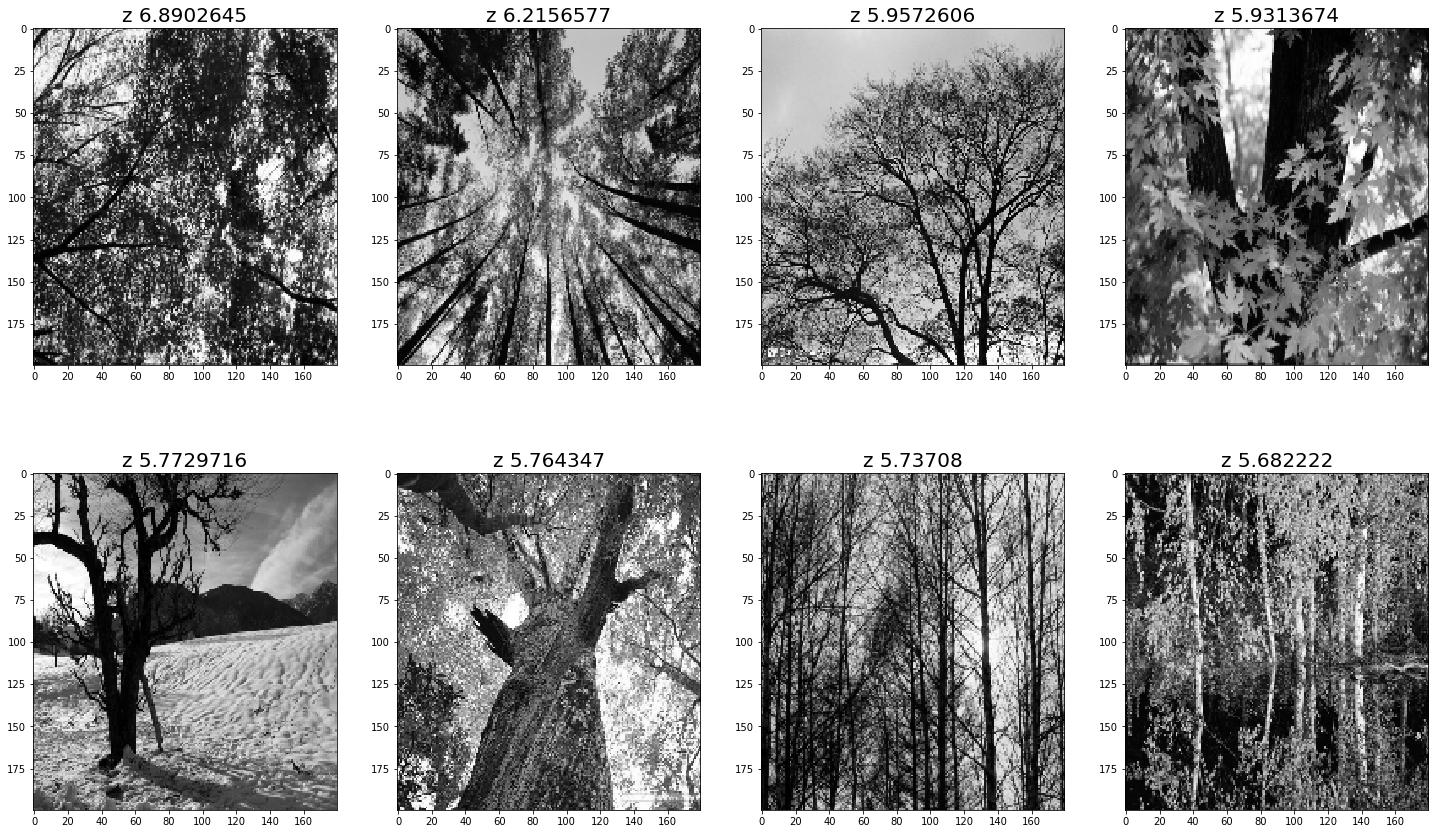

In [43]:
cols = 4
rows = 2
plt.figure(figsize=(25,15))
for i in np.arange(rows * cols):
    plt.subplot(rows, cols, i + 1)
    plt.title("z "+str(z[indexsort[-(i+1)]]),fontsize=20)
    plt.imshow(datasetfull[indexsort[-(i+1)]], plt.cm.gray)

TP= 3013 TN= 183 FP= 27 FN= 46
accuracy=  0.9776690119302539


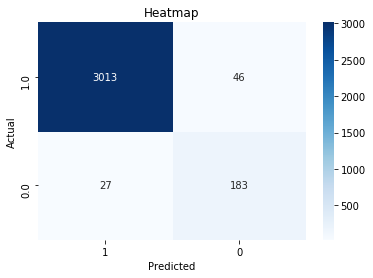

In [44]:
y_true=np.ones(dataset_N)
y_true=np.append(y_true,np.zeros(landscapes.shape[0]))
y_pred=(edistancefull<=percentil_93)*1
#y_pred=(z <= threshold)*1

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print('TP=', tp,'TN=',tn,'FP=',fp,'FN=', fn)
print('accuracy= ', (tp+tn)/(tp+tn+fp+fn))

plt.figure()
plt.title("Heatmap")
prediction_data = {'y_Actual': y_true,'y_Predicted': y_pred}
df = pd.DataFrame(prediction_data, columns=['y_Actual','y_Predicted'])
confusionmatrix1 = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
ax=sns.heatmap(confusionmatrix1, annot=True,cmap='Blues', fmt='.0f');
ax.invert_yaxis()
ax.invert_xaxis()

## Part 3

# classes

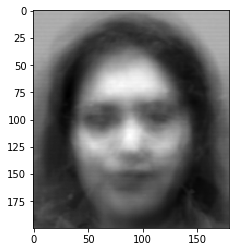

In [45]:
dataclass1=faces94_female
dataset_N2, height, width = dataclass1.shape
mean_class1 = np.mean(dataclass1.reshape(dataset_N2, height*width), axis=0)
plt.imshow(mean_class1.reshape(height, width), plt.cm.gray)

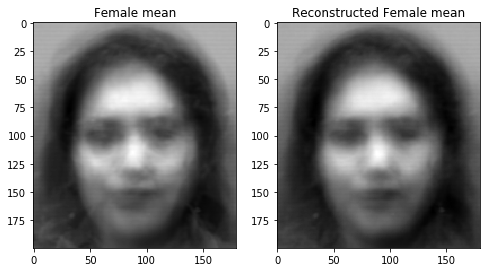

In [46]:
omegaclass1=mean_class1 - np.mean(dataset.reshape(dataset_N, height*width), axis=0)
wclass1=np.dot(omegaclass1,NormEigenvectorsA)#pesos w de cada Eigenface en subespacio generado
Reconstructedc1=np.dot(wclass1,NormEigenvectorsA.T)+mean_all.reshape(height*width)#es mas claro w*vectores propios transpuestos


fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(1,2,1)
plt.title("Female mean")
ax1.imshow(mean_class1.reshape(height, width), plt.cm.gray)
ax2 = fig.add_subplot(1,2,2)
plt.title("Reconstructed Female mean")
ax2.imshow(Reconstructedc1.reshape(height, width), plt.cm.gray)

In [47]:
class1=dataclass1.reshape(dataset_N2, height*width)-mean_all.reshape(height*width)
wclass1total=np.dot(class1,NormEigenvectorsA)
print(wclass1total.shape)
print(wclass1.shape)

(399, 38)
(38,)


In [48]:
Norm=2
edistanceclass1 = np.linalg.norm(np.subtract(wclass1total, wclass1), ord=Norm, axis=1)
print(edistanceclass1.shape)
print(wclass1.shape)

(399,)
(38,)


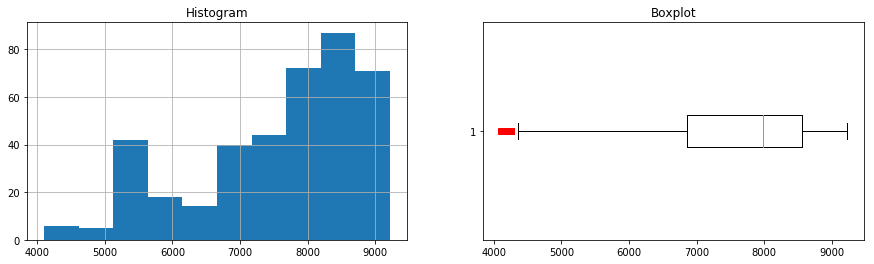

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title('Histogram')
plt.grid(True)
plt.hist(edistanceclass1);
plt.subplot(1,2,2)
plt.title('Boxplot')
plt.boxplot(edistanceclass1, 0, 'rs', 0);
plt.show()

es mujer
8559.91259765625
8021.0435


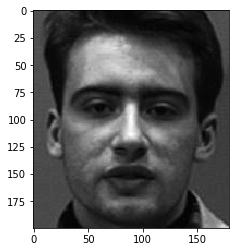

In [50]:
quartile_1, quartile_3 = np.percentile(edistanceclass1, [25, 75])


image_index = np.random.randint(0, high=dataset_N, size=1)[0]
Imagetest=dataset[image_index].reshape(height*width) - np.mean(dataset.reshape(dataset_N, height*width), axis=0)
wtest=np.dot(Imagetest,NormEigenvectorsA)

Norm=2
test = np.linalg.norm(np.subtract(wtest, wclass1), ord=Norm, axis=0)

if test>quartile_3:
        print('no es mujer')
else:
        print('es mujer')
print(quartile_3) 
print(test)    
   
plt.imshow(dataset[image_index], plt.cm.gray)



(3059,)
(38,)


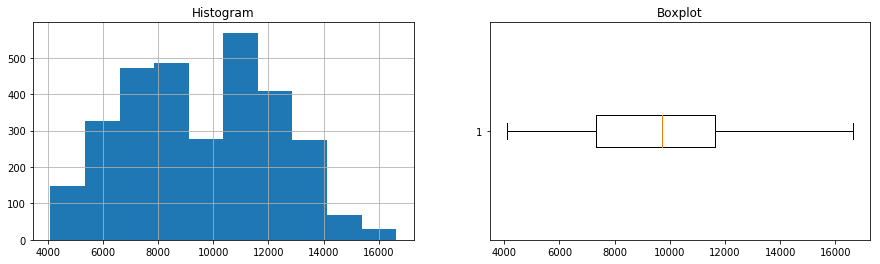

In [51]:
Norm=2
edistanceclass1t = np.linalg.norm(np.subtract(np.dot(data,NormEigenvectorsA), wclass1), ord=Norm, axis=1)
print(edistanceclass1t.shape)
print(wclass1.shape)
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title('Histogram')
plt.grid(True)
plt.hist(edistanceclass1t);
plt.subplot(1,2,2)
plt.title('Boxplot')
plt.boxplot(edistanceclass1t, 0, 'rs', 0);
plt.show()